<a href="https://colab.research.google.com/github/Akash-sh/Sales-Forecasting-with-Prophet-and-HyperparameterTuning/blob/main/TimeSeries_Analysis_using_Prophet_and_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Forecasting using Facebook's Prophet and Hyperparameter Optimisation

### Goal of this Project is to do timeseries analysis and predict next 2 months sales using Facebook Prophet and further optimising the model using Hyperparameter Optimisation

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import numpy as np
import random
import statsmodels.api as sm
# prophet by Facebook
from prophet import Prophet
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

## Understanding the Data

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Groceries_Sales_data.xlsx",parse_dates=[0])

In [ ]:
print('-'*60)
print('*** Head of the dataframe ***')
print('-'*60)
print(df.head())
print('-'*60)
print('*** Tail of the dataframe ***')
print('-'*60)
print(df.tail())

------------------------------------------------------------
*** Head of the dataframe ***
------------------------------------------------------------
        Date    Sales
0 2018-02-01  21199.0
1 2018-02-02  10634.0
2 2018-02-03   7966.0
3 2018-02-04   1353.0
4 2018-02-05   9497.0
------------------------------------------------------------
*** Tail of the dataframe ***
------------------------------------------------------------
          Date    Sales
751 2020-02-22  18723.1
752 2020-02-23   4274.9
753 2020-02-24  45805.7
754 2020-02-25  35566.3
755 2020-02-26  46703.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    756 non-null    datetime64[ns]
 1   Sales   756 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.9 KB


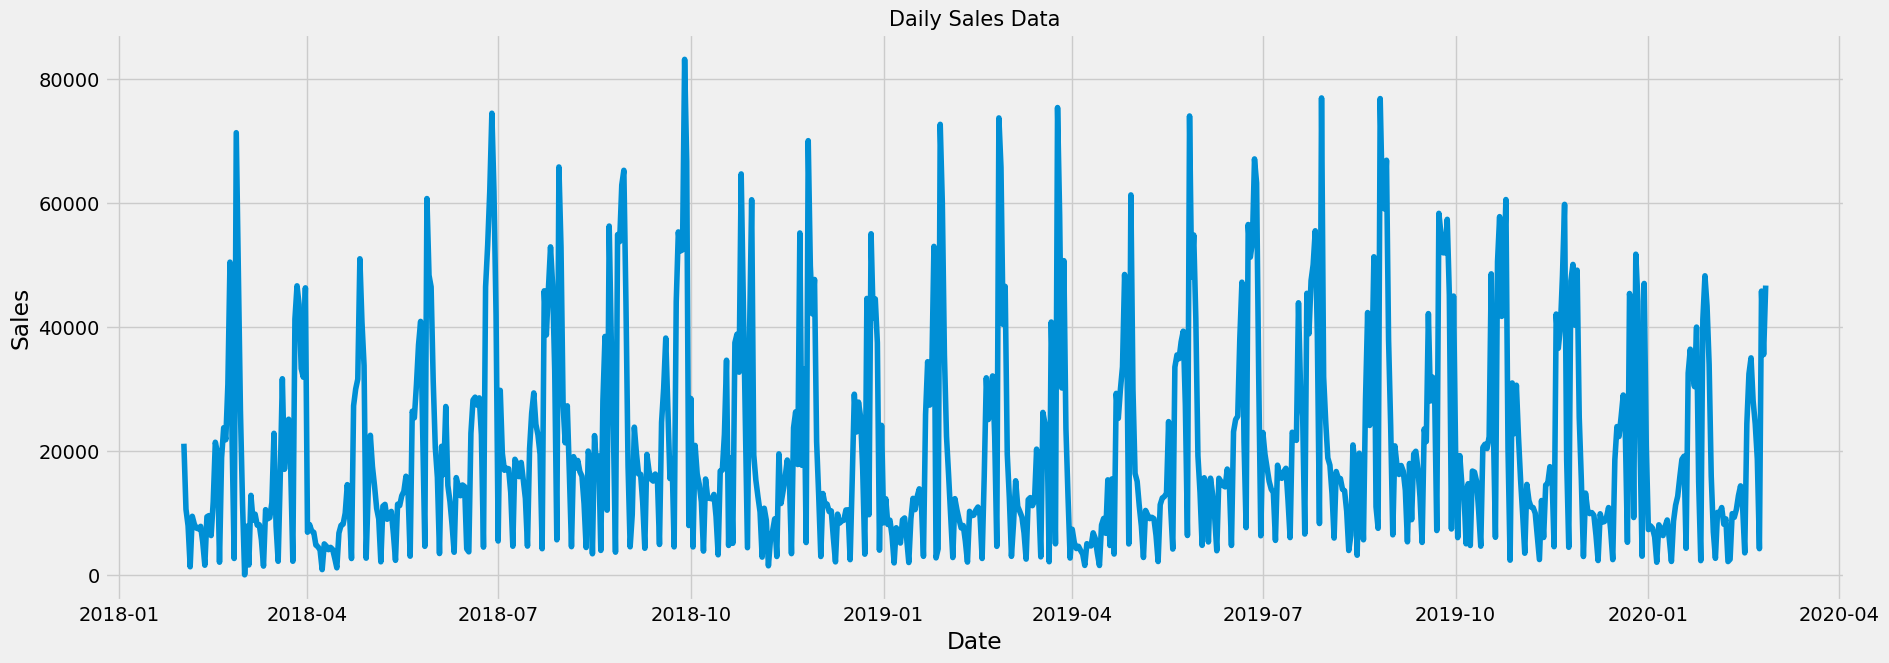

In [ ]:
## Plot the Time series data
fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="Date", y="Sales", data=df)
a.set_title("Daily Sales Data",fontsize=15)
plt.show()

# Exploratory Data Analysis

Creates time series features from Date column.

In [ ]:
def date_features(df, label=None):
    df = df.copy()

    df['date'] = df.Date
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime('%A')
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X
X, y = date_features(df, label='Sales')
df_new = pd.concat([X, y], axis=1)
df_new.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Sales
0,Thursday,1,February,2018,32,1,5,21199.0
1,Friday,1,February,2018,33,2,5,10634.0
2,Saturday,1,February,2018,34,3,5,7966.0
3,Sunday,1,February,2018,35,4,5,1353.0
4,Monday,1,February,2018,36,5,6,9497.0


## Plotting the Features to see trends

* Sales has strong daily and seasonal properties.
* Day of week also seems to show differences in peaks

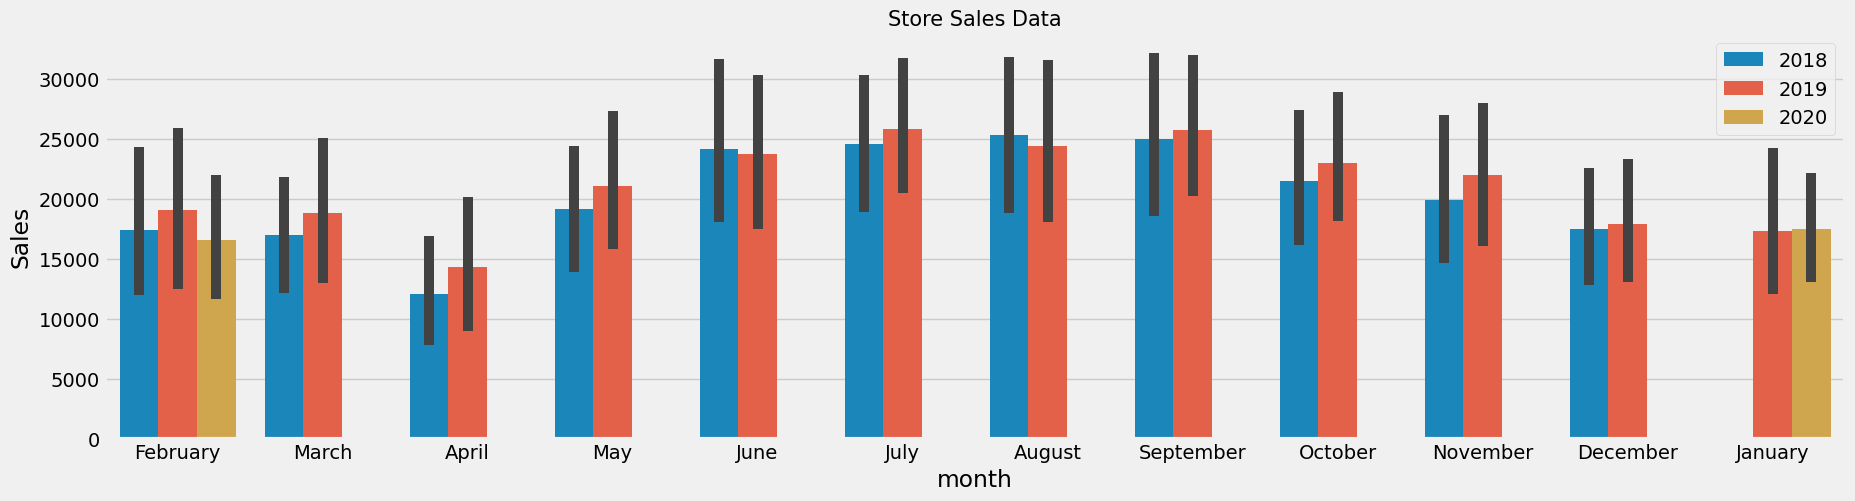

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Sales",hue = 'year',data=df_new)
a.set_title("Store Sales Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

Text(0.5, 1.0, 'Total Sales received By year')

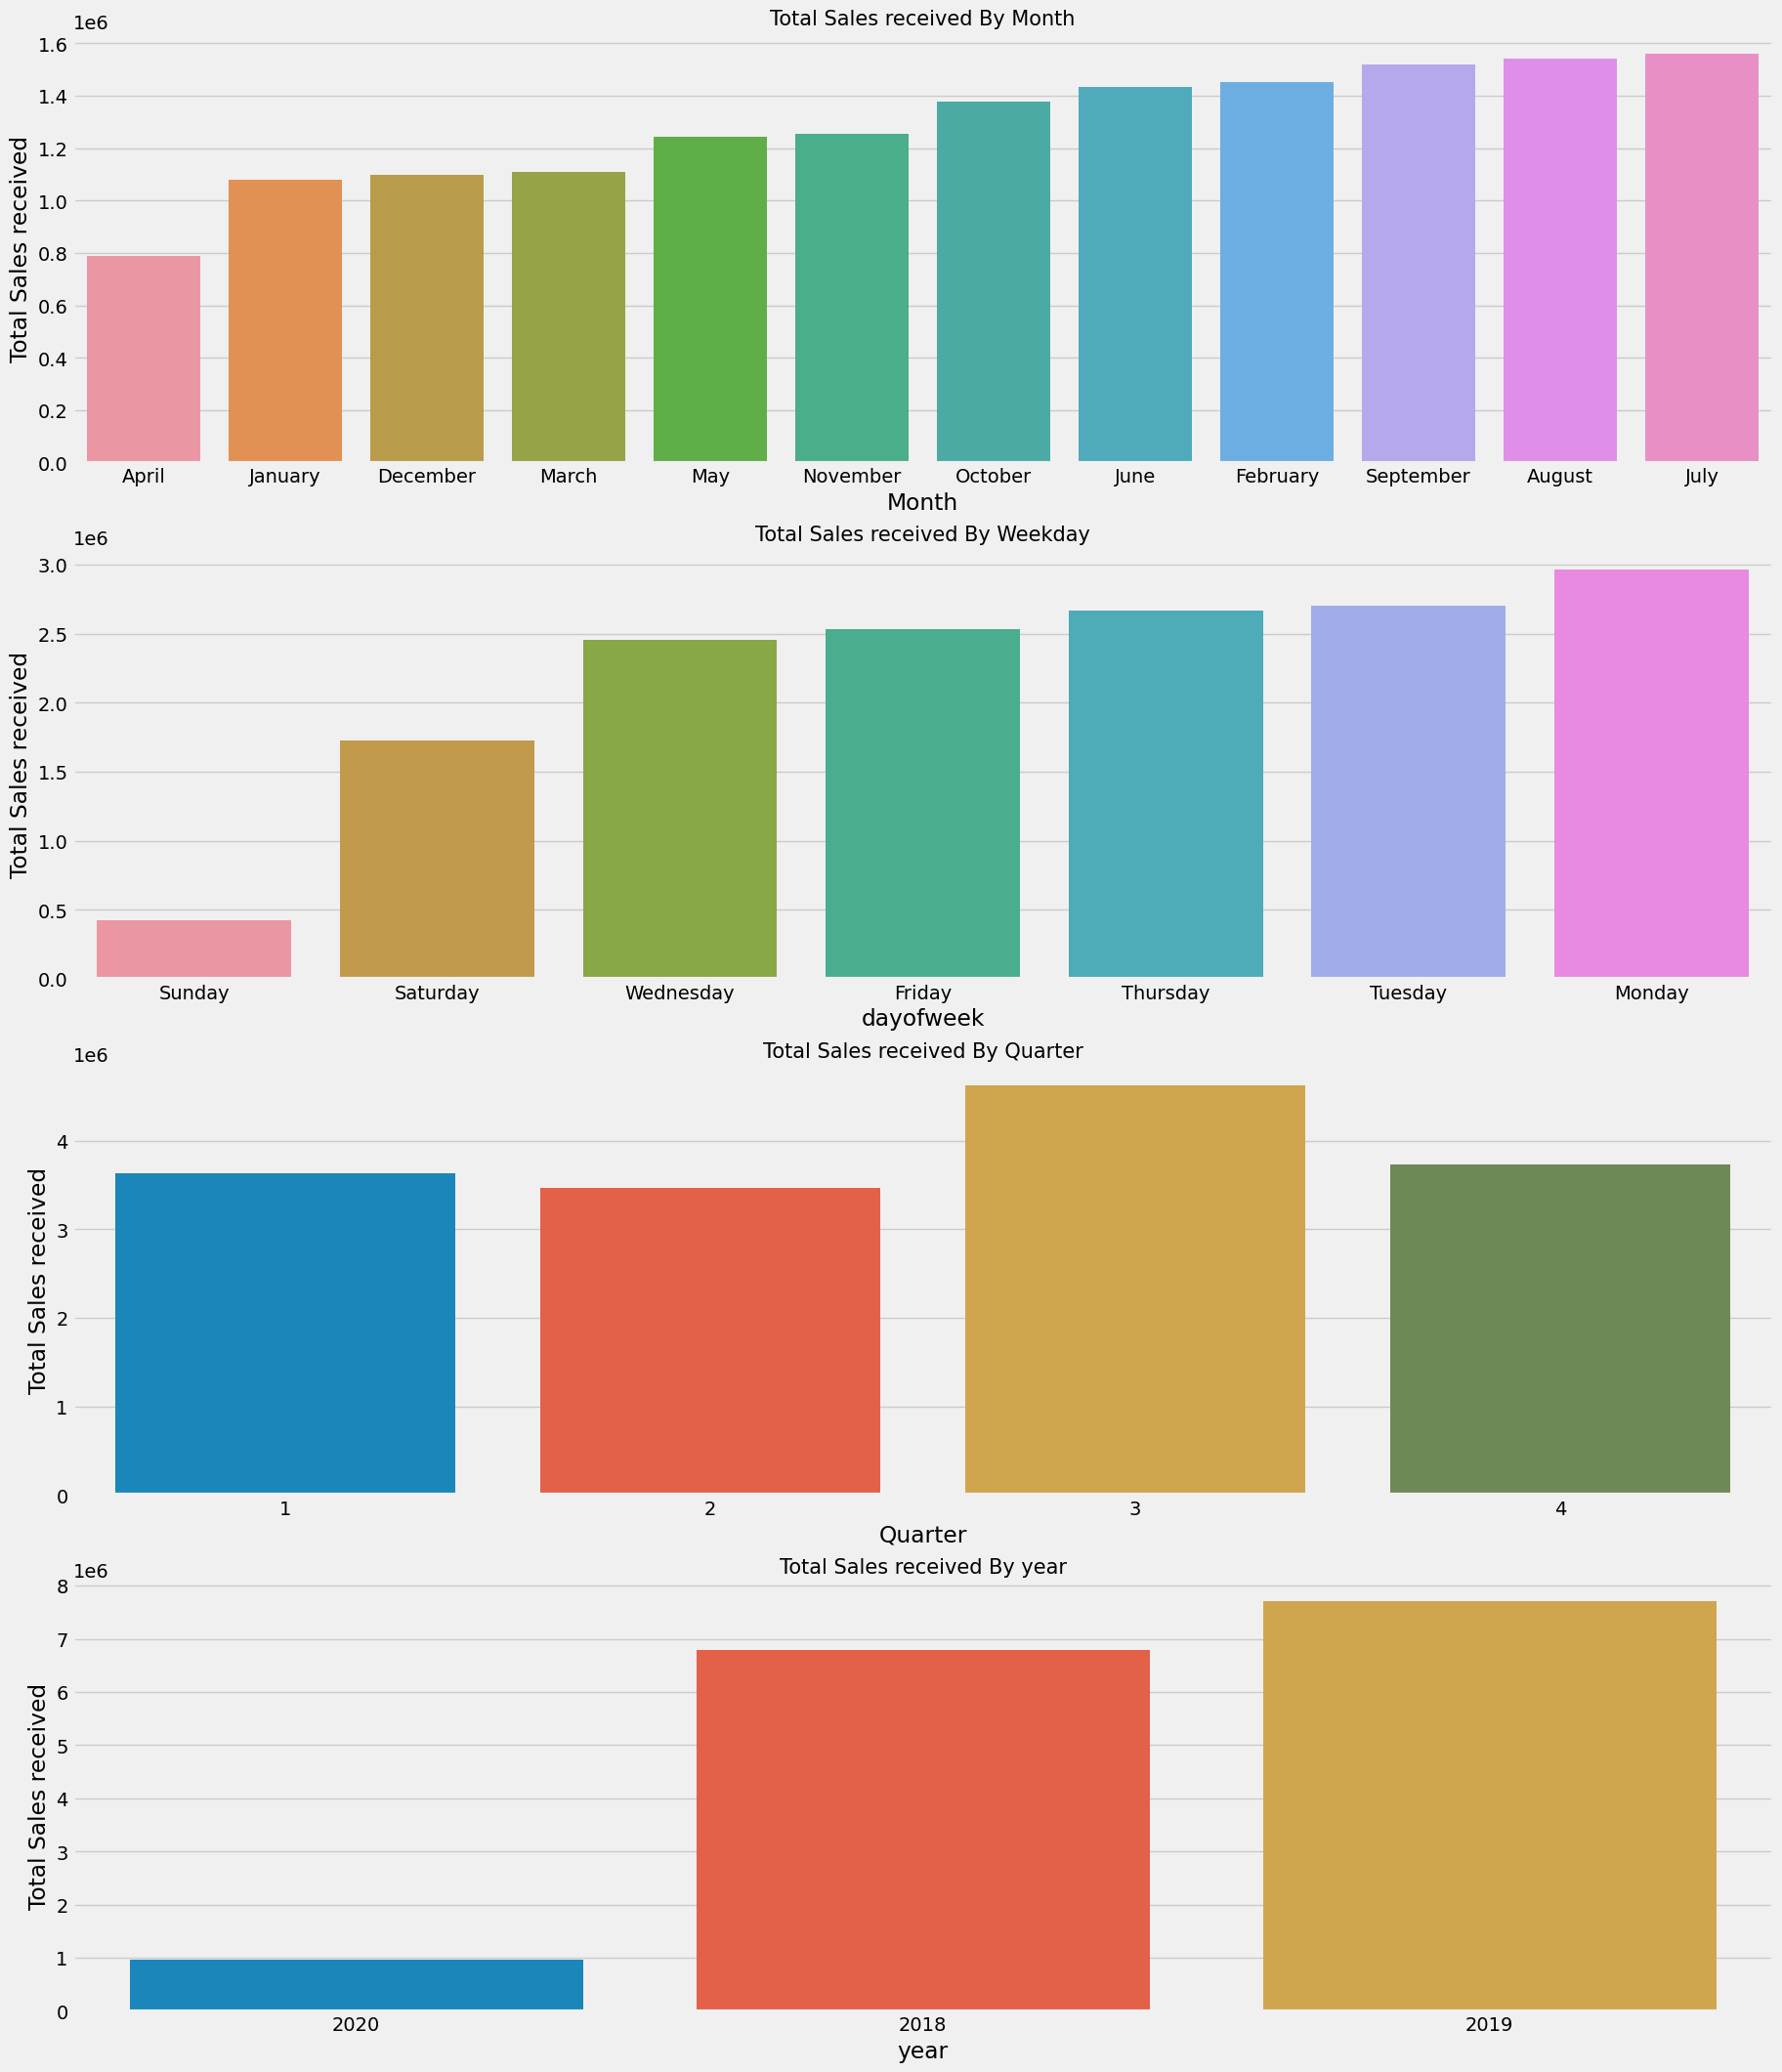

In [ ]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,25)

monthAggregated = pd.DataFrame(df_new.groupby("month")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="month",y="Sales",ax=ax1)
ax1.set(xlabel='Month', ylabel='Total Sales received')
ax1.set_title("Total Sales received By Month",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("dayofweek")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="dayofweek",y="Sales",ax=ax2)
ax2.set(xlabel='dayofweek', ylabel='Total Sales received')
ax2.set_title("Total Sales received By Weekday",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("quarter")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="quarter",y="Sales",ax=ax3)
ax3.set(xlabel='Quarter', ylabel='Total Sales received')
ax3.set_title("Total Sales received By Quarter",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("year")["Sales"].sum()).reset_index().sort_values('Sales')
sns.barplot(data=monthAggregated,x="year",y="Sales",ax=ax4)
ax4.set(xlabel='year', ylabel='Total Sales received')
ax4.set_title("Total Sales received By year",fontsize=15)

In [ ]:
df=df.rename(columns={'Date':'ds','Sales':'y'})
df.head()

,ds,y
0,2018-02-01,21199.0
1,2018-02-02,10634.0
2,2018-02-03,7966.0
3,2018-02-04,1353.0
4,2018-02-05,9497.0


## Train and Test Split

Dividing the dataset into train and test. The train has data from Feb,2018 to Dec,2019. Test Data has 2 months from Jan,2020 to Feb,2020.

In [ ]:
end_date = '2019-12-31'
mask1 = (df['ds'] <= end_date)
mask2 = (df['ds'] > end_date)

In [ ]:
X_tr = df.loc[mask1]
X_tst = df.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (699, 2)
test shape (57, 2)


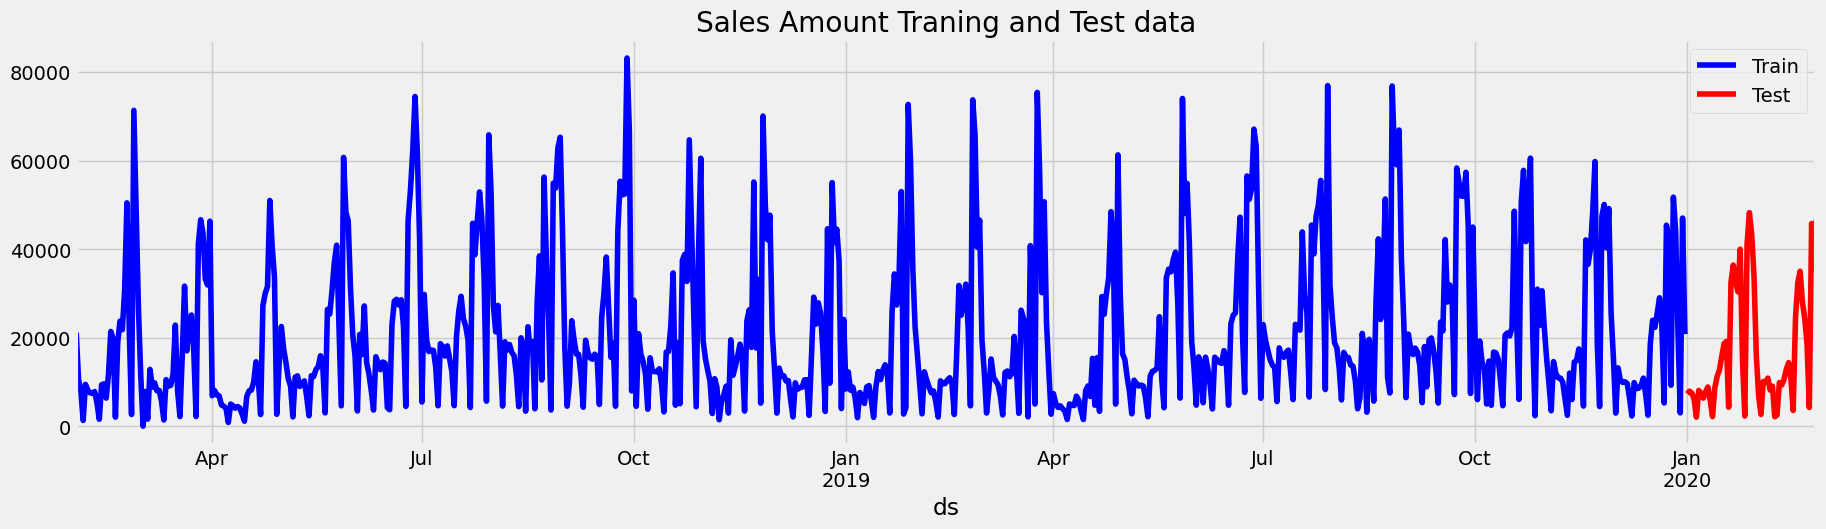

In [ ]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(20,5))
X_tr.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
X_tst.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Sales Amount Traning and Test data')
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Prophet Model

In [ ]:
model =Prophet()
# We can add into Prophet() -> yearly_seasonality=True, daily_seasonality=True
model.fit(X_tr,)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/u2ybwa5z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/r0jszky6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26915', 'data', 'file=/tmp/tmpyc5d3v9p/u2ybwa5z.json', 'init=/tmp/tmpyc5d3v9p/r0jszky6.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelvk76v7ge/prophet_model-20230824090906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:09:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:09:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Now, we will predict by creating future dataframe next dates of train data
make_future_dataframe has include_history = True by default. So the predcition will be done for train data as well.

In [ ]:
future = model.make_future_dataframe(periods=57, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
749,2020-02-20,28047.600552,6947.852129,46853.338977
750,2020-02-21,26738.897030,9593.852266,45593.981143
751,2020-02-22,19206.919082,371.691776,39788.931707
752,2020-02-23,6801.502821,-13795.552488,26078.291497
753,2020-02-24,30663.821975,10744.755491,49579.783645
754,2020-02-25,27926.524028,7977.624034,46905.784391
755,2020-02-26,25527.878896,6188.082624,43663.563869


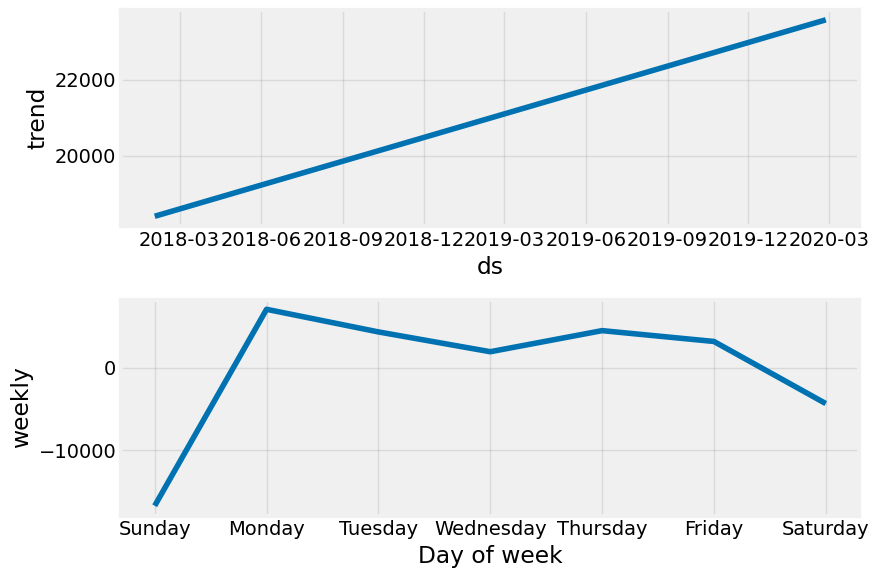

In [ ]:
# Plot the components of the model
fig = model.plot_components(forecast)

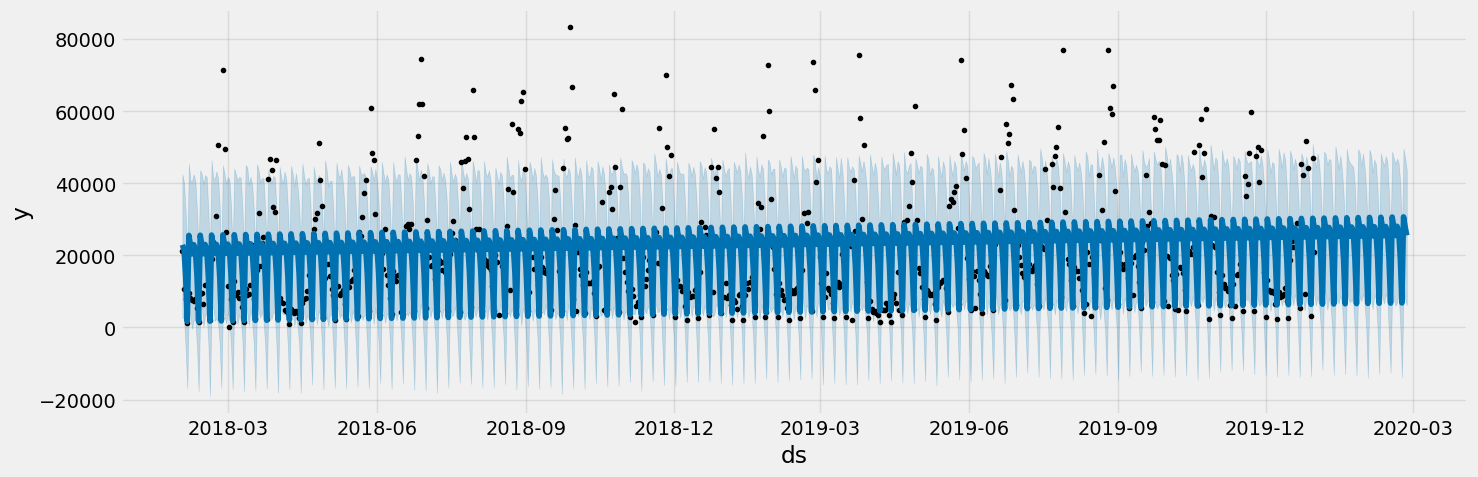

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

## Actual vs Prediction Comparison

In [ ]:
X_tst_forecast = model.predict(X_tst)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
50,2020-02-20,28047.600552,8032.769780,46776.237622
51,2020-02-21,26738.897030,6989.704202,46276.421189
52,2020-02-22,19206.919082,-591.063000,38433.978575
53,2020-02-23,6801.502821,-12940.173795,26538.735607
54,2020-02-24,30663.821975,11719.594717,51073.651204
55,2020-02-25,27926.524028,7942.118596,47096.495973
56,2020-02-26,25527.878896,5143.517550,43306.795417


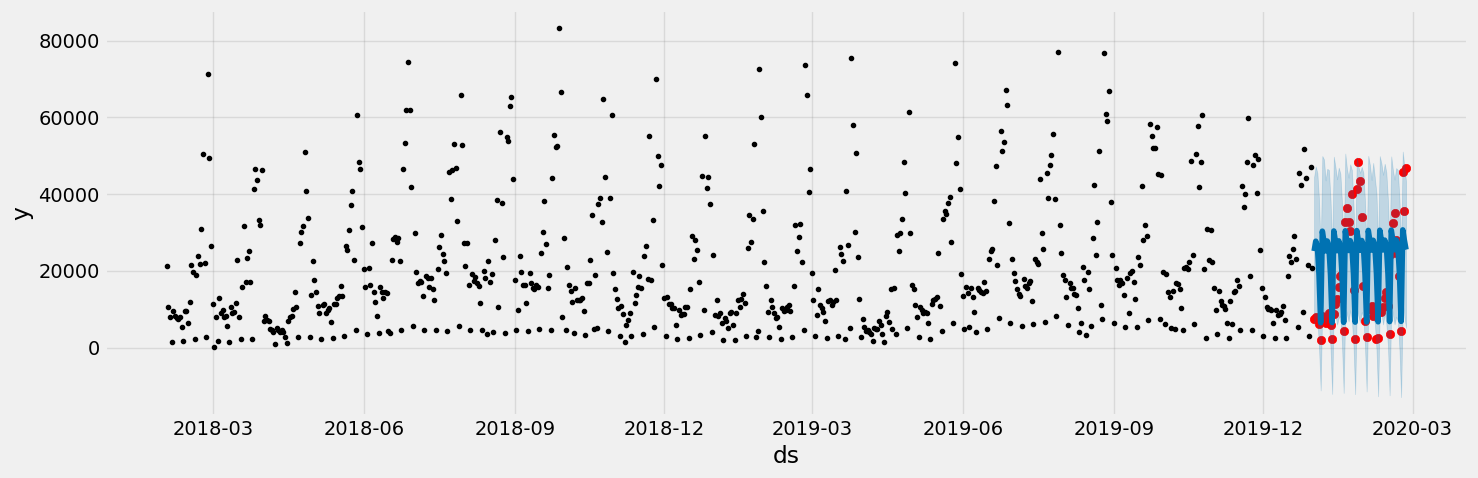

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)

### Compare the test Sales and forecasted Sales

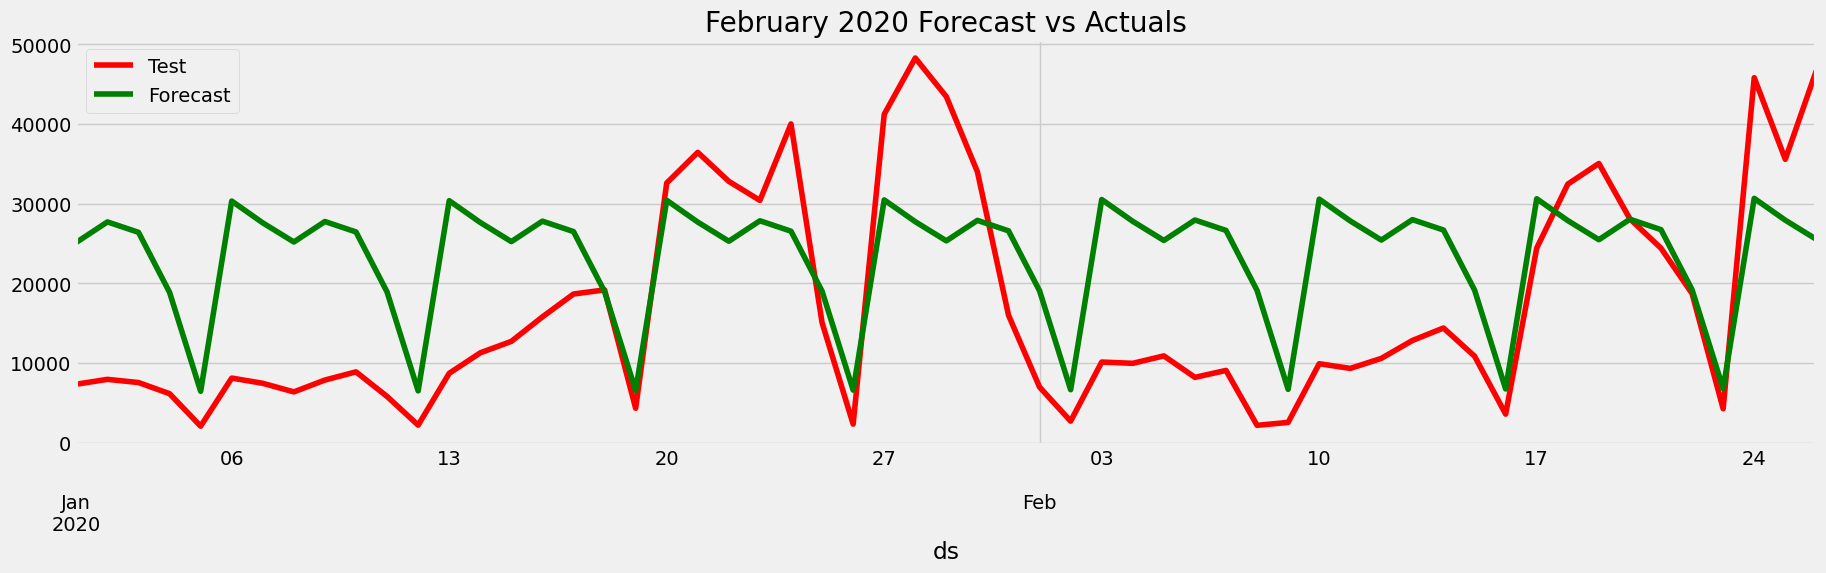

In [ ]:
f, ax = plt.subplots(figsize=(20,5))
f.set_figheight(5)
f.set_figwidth(20)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

**We can see from the above plot, that there is huge gap in prediction. So we need to optimize the model by adding other parameters like holidays, changepoints etc.**

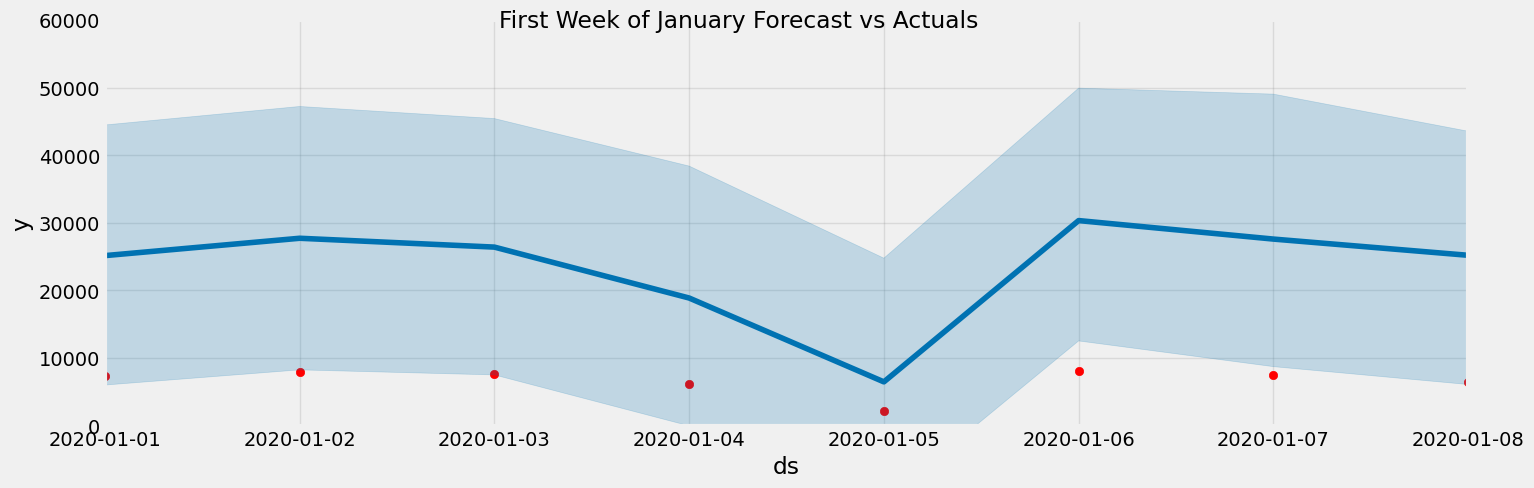

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
# Plot actuals
ax.scatter(X_tst['ds'], X_tst['y'], color='r')

# Plot forecast
fig = model.plot(X_tst_forecast, ax=ax)

# Set x-axis bounds and y-axis limits
ax.set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-01-08'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

In [ ]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 129.3499


### Adding Holidays to the model
We will use **holidays** library to get the US holidays

In [ ]:
import holidays

holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2018,2019,2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

holiday.head()

,ds,holiday
0,2018-01-01,US-Holidays
1,2018-01-15,US-Holidays
2,2018-02-19,US-Holidays
3,2018-05-28,US-Holidays
4,2018-07-04,US-Holidays


In [ ]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(X_tr)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/1kk7xjng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/6lsc36l7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8040', 'data', 'file=/tmp/tmpyc5d3v9p/1kk7xjng.json', 'init=/tmp/tmpyc5d3v9p/6lsc36l7.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelfcy5gog4/prophet_model-20230824091645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:16:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:16:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model_with_holidays.make_future_dataframe(periods=57, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
749,2020-02-20,28244.400621,9962.399416,47757.606497
750,2020-02-21,26893.955433,7624.660280,48082.828581
751,2020-02-22,19356.390601,763.846483,37223.106158
752,2020-02-23,6955.468059,-12329.033522,25999.717434
753,2020-02-24,30969.645912,11517.301465,50105.181169
754,2020-02-25,28108.439354,8349.270616,47771.877611
755,2020-02-26,25710.985093,6205.889501,43217.692859


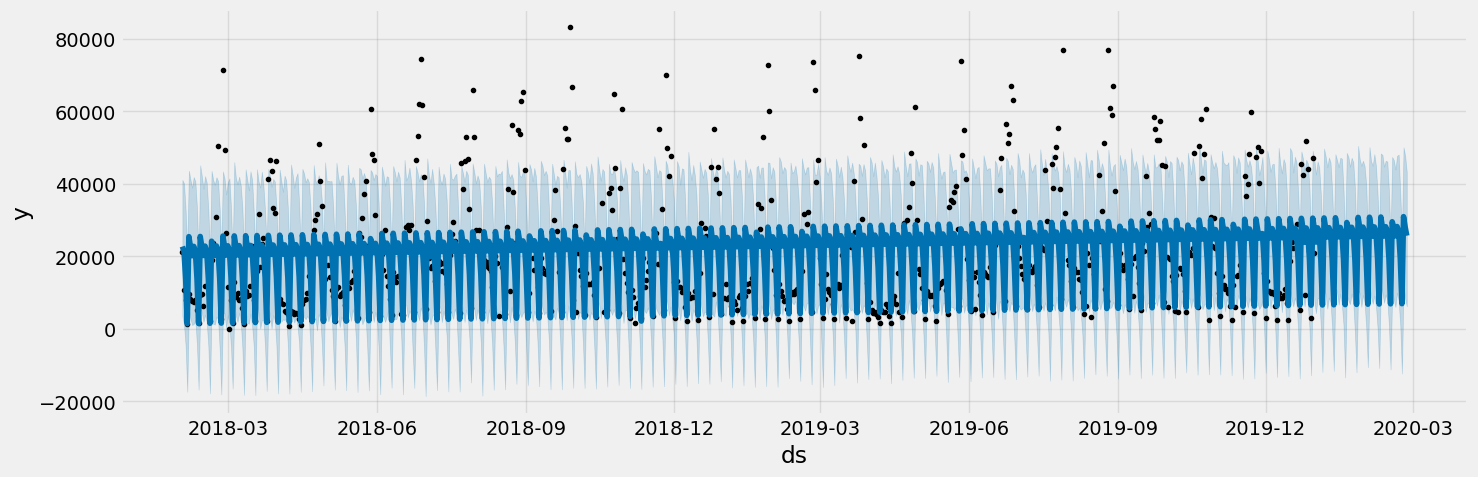

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

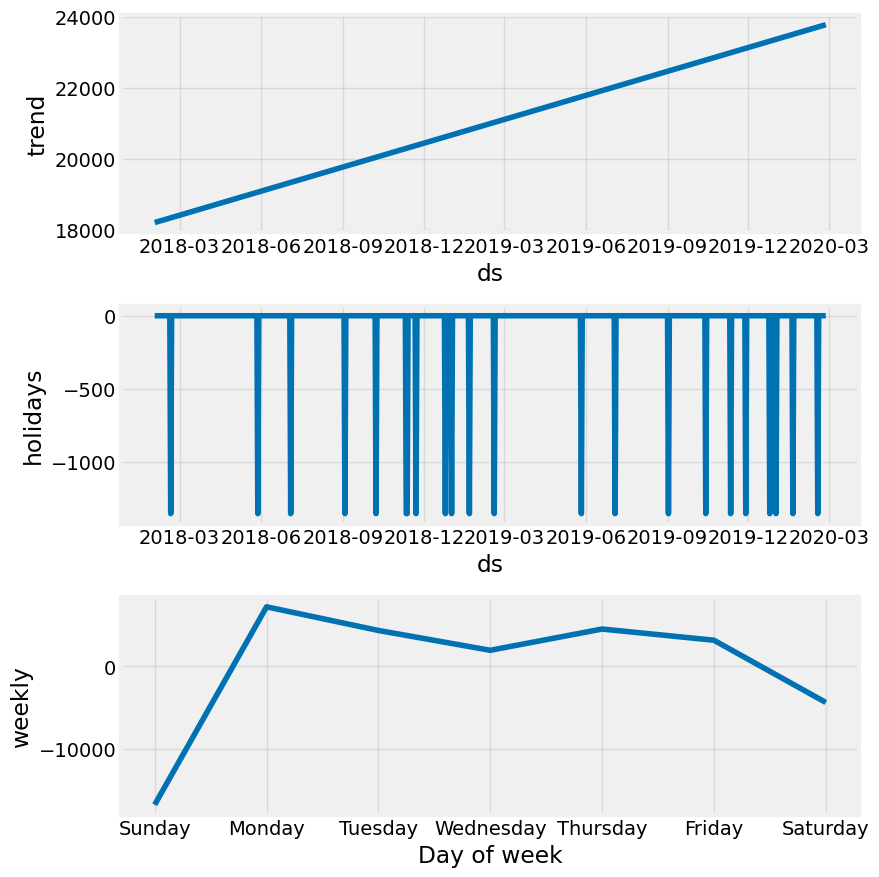

In [ ]:
# Plot the components of the model
fig = model_with_holidays.plot_components(forecast)

In [ ]:
X_tst_forecast_holiday = model_with_holidays.predict(X_tst)
X_tst_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
50,2020-02-20,28244.400621,10851.143169,47744.001559
51,2020-02-21,26893.955433,8621.381778,47215.192429
52,2020-02-22,19356.390601,968.589778,38049.616280
53,2020-02-23,6955.468059,-12763.385287,26740.439839
54,2020-02-24,30969.645912,12944.673512,51253.166884
55,2020-02-25,28108.439354,8589.936085,46321.722437
56,2020-02-26,25710.985093,6029.342426,45331.298454


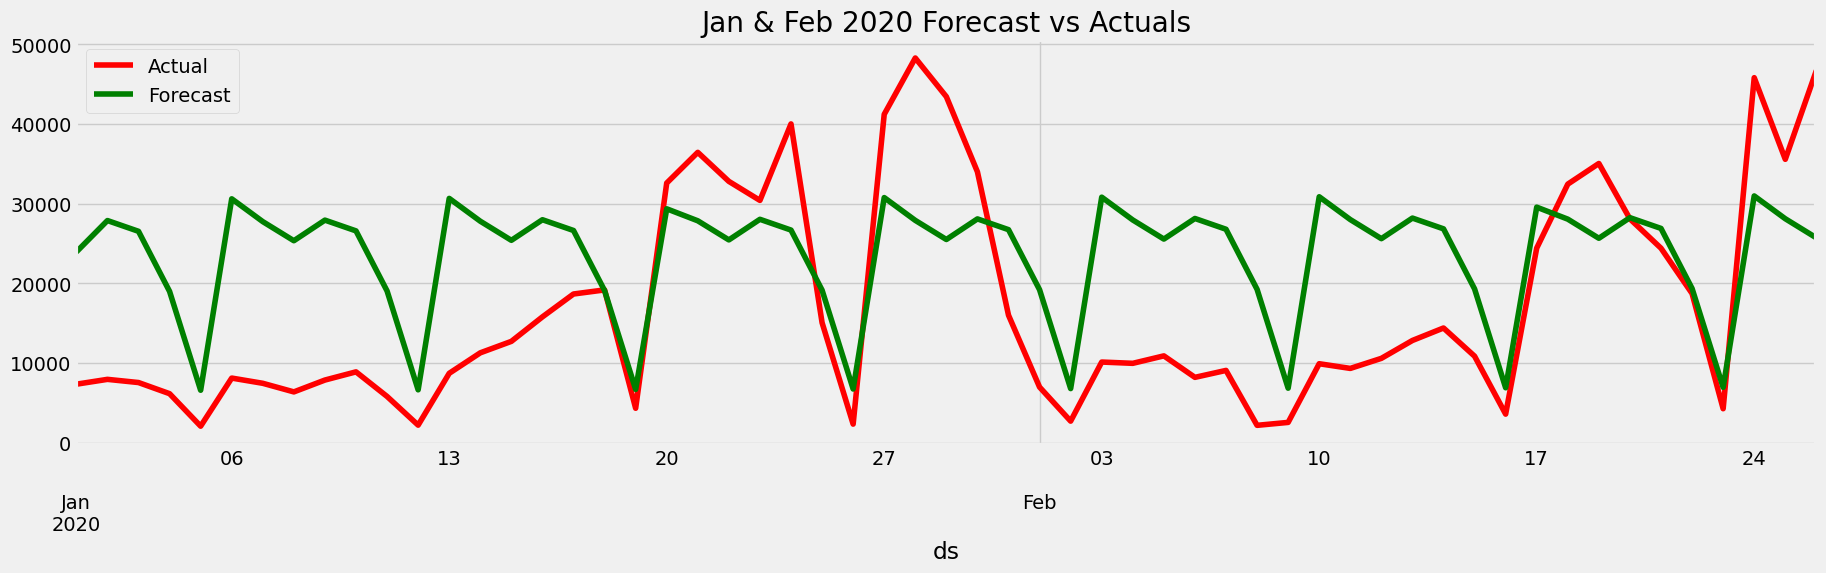

In [ ]:
f, ax = plt.subplots(figsize=(20,5))
f.set_figheight(5)
f.set_figwidth(20)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Jan & Feb 2020 Forecast vs Actuals')
plt.show()

In [ ]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast_holiday['yhat'])
print("MAPE",round(mape,4))

MAPE 130.679


From the above results, we can see that by adding holidays in the model, model performance further reduced. We need to add other parameters to tune the model.

Along with holidays, there are many other hyperparameters which helps in optimizing the prophet model.
1. Holidays
2. Changepoints: (n_changepoints,changepoint_prior_scale)
4. seasonality_mode
5. holiday_prior_scale
6. Seasonalities with fourier_order

We have added holidays to our model and saw its effect.

**n_changepoints** is the number of change happen in the data. Prophet model detects them by its own. By default, its value is 25, which are uniformly placed in the first 80% of the time series. Changing *n_changepoints* can add value to the model.

**changepoint_prior_scale** to indicate how flexible the changepoints are allowed to be. In other words, how much can the changepoints fit to the data. If you make it high it will be more flexible, but you can end up overfitting. By default, this parameter is set to 0.05

**seasonality_mode** There are 2 types model seasonality mode. **Additive & multiplicaticative**. By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. Prophet can model multiplicative seasonality by setting seasonality_mode='multiplicative' in the model.

**holiday_prior_scale** just like changepoint_prior_scale, holiday_prior_scale is used to smoothning the effect of holidays. By default its value is 10, which provides very little regularization. Reducing this parameter dampens holiday effects

**Seasonalities with fourier_order** Prophet model, by default finds the seasonalities and adds the default parameters of the seasonality. We can modify the seasonalities effect by adding custom seasonalities as add_seasonality in the model with different fourier order.Yy default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality.


Now, we will do the hyperparameters tuning using parametergrid. parametergrid will create all the possible parameters combination and will test the model prediction using every combination.
I am taking 4 parameters: n_changepoints, changepoint_prior_scale,seasonality_mode, holiday_prior_scale for tuning.

# HyperParameter Tuning using ParameterGrid

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


# Prophet Model Tuning

In [ ]:
strt='2019-12-31'
end='2020-02-26'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday,
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(X_tr)
    train_forecast = train_model.make_future_dataframe(periods=57, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/h5nsji0o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/e9y42iqu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8717', 'data', 'file=/tmp/tmpyc5d3v9p/h5nsji0o.json', 'init=/tmp/tmpyc5d3v9p/e9y42iqu.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelkz603j_1/prophet_model-20230824092216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:22:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/i5g38zm7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/md6vxs7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27632', 'data', 'file=/tmp/tmpyc5d3v9p/i5g38zm7.json', 'init=/tmp/tmpyc5d3v9p/md6vxs7x.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelq47c58vo/prophet_model-20230824092216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.88318416333382
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:22:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/pg6au2jo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/c7xetrp_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93355', 'data', 'file=/tmp/tmpyc5d3v9p/pg6au2jo.json', 'init=/tmp/tmpyc5d3v9p/c7xetrp_.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelywzhgb_p/prophet_model-20230824092216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 105.40801447332457
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:22:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/wpn_y20_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/9ixur_q0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88372', 'data', 'file=/tmp/tmpyc5d3v9p/wpn_y20_.json', 'init=/tmp/tmpyc5d3v9p/9ixur_q0.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelqs2slhzz/prophet_model-20230824092217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.53212481979217
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:22:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/h_ajtz4t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/zqpr61ok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38539', 'data', 'file=/tmp/tmpyc5d3v9p/h_ajtz4t.json', 'init=/tmp/tmpyc5d3v9p/zqpr61ok.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelrkdqq5l9/prophet_model-20230824092217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 105.37265715869812
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/p_8s6jch.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/cdywxfxr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85476', 'data', 'file=/tmp/tmpyc5d3v9p/p_8s6jch.json', 'init=/tmp/tmpyc5d3v9p/cdywxfxr.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelgqit5_3u/prophet_model-20230824092218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.46764672208867
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/lfoksxf8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/fh49ig3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61719', 'data', 'file=/tmp/tmpyc5d3v9p/lfoksxf8.json', 'init=/tmp/tmpyc5d3v9p/fh49ig3x.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelbddup06a/prophet_model-20230824092218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 105.36369024762887
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/k05fhdtc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ltj2ymx8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14186', 'data', 'file=/tmp/tmpyc5d3v9p/k05fhdtc.json', 'init=/tmp/tmpyc5d3v9p/ltj2ymx8.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model3d96vb3l/prophet_model-20230824092219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 105.63835313841304
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:22:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/1_jbmi2j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/rf20_8zk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58702', 'data', 'file=/tmp/tmpyc5d3v9p/1_jbmi2j.json', 'init=/tmp/tmpyc5d3v9p/rf20_8zk.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelg9gtelwk/prophet_model-20230824092219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.66690509842289
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:22:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/kq1i0e00.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/03x6481d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2615', 'data', 'file=/tmp/tmpyc5d3v9p/kq1i0e00.json', 'init=/tmp/tmpyc5d3v9p/03x6481d.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelx4100yzp/prophet_model-20230824092220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 105.01653961295787
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:22:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/c7c39i2u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/5g4jd0_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82860', 'data', 'file=/tmp/tmpyc5d3v9p/c7c39i2u.json', 'init=/tmp/tmpyc5d3v9p/5g4jd0_m.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_models549p833/prophet_model-20230824092220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.90915919134942
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:22:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/gnstz8df.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/fao1cuii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7181', 'data', 'file=/tmp/tmpyc5d3v9p/gnstz8df.json', 'init=/tmp/tmpyc5d3v9p/fao1cuii.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model8gino0pb/prophet_model-20230824092221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 105.24213732246986
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:22:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/tuw_zdpe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/sux32bad.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12351', 'data', 'file=/tmp/tmpyc5d3v9p/tuw_zdpe.json', 'init=/tmp/tmpyc5d3v9p/sux32bad.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelcjh9w6_w/prophet_model-20230824092221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.97516644343239
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:22:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/kip95pl7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/r5vn1qnv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43074', 'data', 'file=/tmp/tmpyc5d3v9p/kip95pl7.json', 'init=/tmp/tmpyc5d3v9p/r5vn1qnv.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelxu6gmep7/prophet_model-20230824092221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.63762536961399
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/sp13b98h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/c2pizgwl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26357', 'data', 'file=/tmp/tmpyc5d3v9p/sp13b98h.json', 'init=/tmp/tmpyc5d3v9p/c2pizgwl.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelng3sh04z/prophet_model-20230824092222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.63716021616678
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/1nxpk683.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/cg1az5sd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14287', 'data', 'file=/tmp/tmpyc5d3v9p/1nxpk683.json', 'init=/tmp/tmpyc5d3v9p/cg1az5sd.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelkibb06bu/prophet_model-20230824092222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.97611058001901
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:22:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/s33iwt2l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/m4sz5a_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14819', 'data', 'file=/tmp/tmpyc5d3v9p/s33iwt2l.json', 'init=/tmp/tmpyc5d3v9p/m4sz5a_o.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeli2_ks88i/prophet_model-20230824092223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.73106838064221
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:22:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/96eieiyk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/o4qdw1as.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14875', 'data', 'file=/tmp/tmpyc5d3v9p/96eieiyk.json', 'init=/tmp/tmpyc5d3v9p/o4qdw1as.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelr99uludk/prophet_model-20230824092223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.37025246205837
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:22:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/wlnvflzn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/rv7af8vy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84669', 'data', 'file=/tmp/tmpyc5d3v9p/wlnvflzn.json', 'init=/tmp/tmpyc5d3v9p/rv7af8vy.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeltkrqzgj0/prophet_model-20230824092224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.90467057911626
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:22:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/mny6bsc5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/xe7a3vb7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=764', 'data', 'file=/tmp/tmpyc5d3v9p/mny6bsc5.json', 'init=/tmp/tmpyc5d3v9p/xe7a3vb7.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelmiuoeny_/prophet_model-20230824092224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.56607680968595
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:22:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ge1pa7rc.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.3177023691497
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/93jbianf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54313', 'data', 'file=/tmp/tmpyc5d3v9p/ge1pa7rc.json', 'init=/tmp/tmpyc5d3v9p/93jbianf.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model9vh_jh9_/prophet_model-20230824092225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ux8toilx.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.55826566672688
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/b_43hjce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95525', 'data', 'file=/tmp/tmpyc5d3v9p/ux8toilx.json', 'init=/tmp/tmpyc5d3v9p/b_43hjce.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelu9o1wyve/prophet_model-20230824092226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/0big0v3l.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.74570288548031
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/qomezwg1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35012', 'data', 'file=/tmp/tmpyc5d3v9p/0big0v3l.json', 'init=/tmp/tmpyc5d3v9p/qomezwg1.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeldllug899/prophet_model-20230824092226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/2wghsixk.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.15143348160049
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/to0gezcb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20524', 'data', 'file=/tmp/tmpyc5d3v9p/2wghsixk.json', 'init=/tmp/tmpyc5d3v9p/to0gezcb.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model_bywux7a/prophet_model-20230824092227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ddjw_om6.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 105.06654811736367
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/_z0xgn3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3794', 'data', 'file=/tmp/tmpyc5d3v9p/ddjw_om6.json', 'init=/tmp/tmpyc5d3v9p/_z0xgn3c.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelsuzfk6kb/prophet_model-20230824092228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/vjg06dq8.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.91361147987222
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/mlh4vbky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66516', 'data', 'file=/tmp/tmpyc5d3v9p/vjg06dq8.json', 'init=/tmp/tmpyc5d3v9p/mlh4vbky.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeli8u21g9z/prophet_model-20230824092229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/_jcb5pok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/eztmryh4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Mean Absolute Percentage Error(MAPE)------------------------------------ 104.90338122658439
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:22:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/b2cjaoz6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/x4hpjvnp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28145', 'data', 'file=/tmp/tmpyc5d3v9p/b2cjaoz6.json', 'init=/tmp/tmpyc5d3v9p/x4hpjvnp.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelnbf_6i4e/prophet_model-20230824092230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.39238047938977
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:22:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/3swdyie0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/go1q_0o5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51826', 'data', 'file=/tmp/tmpyc5d3v9p/3swdyie0.json', 'init=/tmp/tmpyc5d3v9p/go1q_0o5.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelmxm2ph0f/prophet_model-20230824092230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.91235206799006
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:22:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/7v0pxv1i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/toqoz57g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86054', 'data', 'file=/tmp/tmpyc5d3v9p/7v0pxv1i.json', 'init=/tmp/tmpyc5d3v9p/toqoz57g.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelpqwe1g6i/prophet_model-20230824092231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 105.88952731940411
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:22:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/vsx_auyt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/fjcrua86.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72025', 'data', 'file=/tmp/tmpyc5d3v9p/vsx_auyt.json', 'init=/tmp/tmpyc5d3v9p/fjcrua86.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model_1jhh00x/prophet_model-20230824092232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.88567754454061
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:22:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/biqvfjqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/5wcuc3oj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11246', 'data', 'file=/tmp/tmpyc5d3v9p/biqvfjqj.json', 'init=/tmp/tmpyc5d3v9p/5wcuc3oj.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelks8i6n0h/prophet_model-20230824092232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.65010424957757
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:22:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/dbna60ai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/bsy3i_jy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72095', 'data', 'file=/tmp/tmpyc5d3v9p/dbna60ai.json', 'init=/tmp/tmpyc5d3v9p/bsy3i_jy.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelmf2xr1nc/prophet_model-20230824092232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.04079615381514
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:22:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/4rzz89z_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/qv7lqtkt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53467', 'data', 'file=/tmp/tmpyc5d3v9p/4rzz89z_.json', 'init=/tmp/tmpyc5d3v9p/qv7lqtkt.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelompomh1l/prophet_model-20230824092233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 105.0494205416397
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:22:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ccs_4xdc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/27phv7bf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=897', 'data', 'file=/tmp/tmpyc5d3v9p/ccs_4xdc.json', 'init=/tmp/tmpyc5d3v9p/27phv7bf.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model0a7d4s_1/prophet_model-20230824092233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.09427328470736
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:22:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/cfdbrr_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/lmclw1cz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28803', 'data', 'file=/tmp/tmpyc5d3v9p/cfdbrr_m.json', 'init=/tmp/tmpyc5d3v9p/lmclw1cz.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model4aykdpu8/prophet_model-20230824092234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 105.30554276868023
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:22:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/0b_qn0pc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/i81bwgsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16162', 'data', 'file=/tmp/tmpyc5d3v9p/0b_qn0pc.json', 'init=/tmp/tmpyc5d3v9p/i81bwgsu.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelhso4cipm/prophet_model-20230824092234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.92576724793679
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:22:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/3y9myf63.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/y35lcx0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1404', 'data', 'file=/tmp/tmpyc5d3v9p/3y9myf63.json', 'init=/tmp/tmpyc5d3v9p/y35lcx0b.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeli61808ag/prophet_model-20230824092234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.44170941063852
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:22:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/w_jhb9_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/4lwq52gr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44552', 'data', 'file=/tmp/tmpyc5d3v9p/w_jhb9_u.json', 'init=/tmp/tmpyc5d3v9p/4lwq52gr.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model6o3ppcwf/prophet_model-20230824092235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.33613729118896
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:22:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/5f3rq1lq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/oaw_pnbp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48933', 'data', 'file=/tmp/tmpyc5d3v9p/5f3rq1lq.json', 'init=/tmp/tmpyc5d3v9p/oaw_pnbp.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model9hqamwq4/prophet_model-20230824092235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 105.62469593030539
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:22:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/rjrnwmsi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/l2ddksk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24344', 'data', 'file=/tmp/tmpyc5d3v9p/rjrnwmsi.json', 'init=/tmp/tmpyc5d3v9p/l2ddksk4.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeled70xs86/prophet_model-20230824092236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.61568798296909
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/luftllq0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/l6ne2h0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26874', 'data', 'file=/tmp/tmpyc5d3v9p/luftllq0.json', 'init=/tmp/tmpyc5d3v9p/l6ne2h0x.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelf5e4qtjv/prophet_model-20230824092236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 106.4048974703093
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/wdwnz_un.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/32f69q3d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38591', 'data', 'file=/tmp/tmpyc5d3v9p/wdwnz_un.json', 'init=/tmp/tmpyc5d3v9p/32f69q3d.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeloq4gicry/prophet_model-20230824092237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.4869608444446
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:22:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/my69woeh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/1l2qijf1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15671', 'data', 'file=/tmp/tmpyc5d3v9p/my69woeh.json', 'init=/tmp/tmpyc5d3v9p/1l2qijf1.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelm4vlx3_c/prophet_model-20230824092237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.3243845902561
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:22:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/3e9eyaby.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/u0koljh2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72588', 'data', 'file=/tmp/tmpyc5d3v9p/3e9eyaby.json', 'init=/tmp/tmpyc5d3v9p/u0koljh2.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeley7qwmns/prophet_model-20230824092238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.20650209253104
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:22:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/dvkhx_ed.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ev2r7a_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92213', 'data', 'file=/tmp/tmpyc5d3v9p/dvkhx_ed.json', 'init=/tmp/tmpyc5d3v9p/ev2r7a_q.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelqyns6wp3/prophet_model-20230824092238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.26810758018293
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:22:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/7l6siovi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/rjn4t16r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53288', 'data', 'file=/tmp/tmpyc5d3v9p/7l6siovi.json', 'init=/tmp/tmpyc5d3v9p/rjn4t16r.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model_6l_4nsx/prophet_model-20230824092238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.43590354023671
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:22:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/xh2pep7u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/cnmy9njw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45535', 'data', 'file=/tmp/tmpyc5d3v9p/xh2pep7u.json', 'init=/tmp/tmpyc5d3v9p/cnmy9njw.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelyhyd8aci/prophet_model-20230824092239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.89372500324299
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:22:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/qxcemehn.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.41037003305811
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/76ld_cak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59', 'data', 'file=/tmp/tmpyc5d3v9p/qxcemehn.json', 'init=/tmp/tmpyc5d3v9p/76ld_cak.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelbvd6aaut/prophet_model-20230824092239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/apdcbctg.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.03299750090645
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/3d88iu8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23203', 'data', 'file=/tmp/tmpyc5d3v9p/apdcbctg.json', 'init=/tmp/tmpyc5d3v9p/3d88iu8y.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeljz683e72/prophet_model-20230824092240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/f1l9qa53.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.85497542986323
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/yx4r3pyz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54677', 'data', 'file=/tmp/tmpyc5d3v9p/f1l9qa53.json', 'init=/tmp/tmpyc5d3v9p/yx4r3pyz.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelgy7ty6ik/prophet_model-20230824092241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/i2xptxdm.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.39351145107281
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/w02897f3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9302', 'data', 'file=/tmp/tmpyc5d3v9p/i2xptxdm.json', 'init=/tmp/tmpyc5d3v9p/w02897f3.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelul368fbb/prophet_model-20230824092242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/hbknjrbz.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.05876242587337
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/pvsn4cy1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32517', 'data', 'file=/tmp/tmpyc5d3v9p/hbknjrbz.json', 'init=/tmp/tmpyc5d3v9p/pvsn4cy1.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelmfehwj02/prophet_model-20230824092242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/s5nr9zcc.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.51782633418864
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/c1or3ios.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50758', 'data', 'file=/tmp/tmpyc5d3v9p/s5nr9zcc.json', 'init=/tmp/tmpyc5d3v9p/c1or3ios.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelrc5rrk6t/prophet_model-20230824092243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/bjxrid4r.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.72217460446913
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/n5xjp0du.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72421', 'data', 'file=/tmp/tmpyc5d3v9p/bjxrid4r.json', 'init=/tmp/tmpyc5d3v9p/n5xjp0du.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelx_fmw1gg/prophet_model-20230824092244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/zwo_6x9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/mt9w0en4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Mean Absolute Percentage Error(MAPE)------------------------------------ 100.54576621939361
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:22:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/03qdir42.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/_u4fh99c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50574', 'data', 'file=/tmp/tmpyc5d3v9p/03qdir42.json', 'init=/tmp/tmpyc5d3v9p/_u4fh99c.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model49r05c1m/prophet_model-20230824092245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.04469507232017
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:22:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ry21g9b8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ye_qsaz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73187', 'data', 'file=/tmp/tmpyc5d3v9p/ry21g9b8.json', 'init=/tmp/tmpyc5d3v9p/ye_qsaz1.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelb2r3ap71/prophet_model-20230824092245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.85367611769306
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:22:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/zlelotpm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/p30vsbe8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15070', 'data', 'file=/tmp/tmpyc5d3v9p/zlelotpm.json', 'init=/tmp/tmpyc5d3v9p/p30vsbe8.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelhaa3rchj/prophet_model-20230824092246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.35756432310959
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:22:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/c1uho3ch.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ld4clf8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10037', 'data', 'file=/tmp/tmpyc5d3v9p/c1uho3ch.json', 'init=/tmp/tmpyc5d3v9p/ld4clf8f.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeld_5j1ry6/prophet_model-20230824092246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.29528621171049
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:22:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/l6p7lpg7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/jw5n3x72.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40289', 'data', 'file=/tmp/tmpyc5d3v9p/l6p7lpg7.json', 'init=/tmp/tmpyc5d3v9p/jw5n3x72.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelwptnkihm/prophet_model-20230824092247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.3182956780096
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:22:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/67p8m2ot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/reacrer0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48313', 'data', 'file=/tmp/tmpyc5d3v9p/67p8m2ot.json', 'init=/tmp/tmpyc5d3v9p/reacrer0.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model165wmqv8/prophet_model-20230824092247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 105.11126863264167
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:22:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/bu9hxtz2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/hbafvtmx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62205', 'data', 'file=/tmp/tmpyc5d3v9p/bu9hxtz2.json', 'init=/tmp/tmpyc5d3v9p/hbafvtmx.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_models8ubm7ch/prophet_model-20230824092248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.60342479651263
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:22:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/wbckdrmh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/i9c61l5v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80455', 'data', 'file=/tmp/tmpyc5d3v9p/wbckdrmh.json', 'init=/tmp/tmpyc5d3v9p/i9c61l5v.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model9glxhbel/prophet_model-20230824092248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 109.55509211868228
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:22:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/2mylgdbl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/yg7bn68j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19620', 'data', 'file=/tmp/tmpyc5d3v9p/2mylgdbl.json', 'init=/tmp/tmpyc5d3v9p/yg7bn68j.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelsvec2r3j/prophet_model-20230824092249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.84990377370028
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:22:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/wmr0bcso.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/fmdzmocm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53892', 'data', 'file=/tmp/tmpyc5d3v9p/wmr0bcso.json', 'init=/tmp/tmpyc5d3v9p/fmdzmocm.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelsiot2xss/prophet_model-20230824092249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 106.13813409708656
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:22:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/177biiok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/elxv930m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33828', 'data', 'file=/tmp/tmpyc5d3v9p/177biiok.json', 'init=/tmp/tmpyc5d3v9p/elxv930m.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelt3kwdc2x/prophet_model-20230824092250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.66113127458799
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:22:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/i_uqrwoe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/g38079fu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50724', 'data', 'file=/tmp/tmpyc5d3v9p/i_uqrwoe.json', 'init=/tmp/tmpyc5d3v9p/g38079fu.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeld22nrm_c/prophet_model-20230824092250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.839102392021
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:22:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/aouw6hb9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/2x4eh0wz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79964', 'data', 'file=/tmp/tmpyc5d3v9p/aouw6hb9.json', 'init=/tmp/tmpyc5d3v9p/2x4eh0wz.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model814g2zh1/prophet_model-20230824092251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.99569432156332
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:22:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/9cqit0iv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/7ie7fh09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21278', 'data', 'file=/tmp/tmpyc5d3v9p/9cqit0iv.json', 'init=/tmp/tmpyc5d3v9p/7ie7fh09.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelkdzu_6fh/prophet_model-20230824092251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.95179303406874
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:22:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/apcwp5a1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/bfkten1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80081', 'data', 'file=/tmp/tmpyc5d3v9p/apcwp5a1.json', 'init=/tmp/tmpyc5d3v9p/bfkten1o.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelex3utwqh/prophet_model-20230824092251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.60102590681653
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:22:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/efjxilg7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/028i83q2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53748', 'data', 'file=/tmp/tmpyc5d3v9p/efjxilg7.json', 'init=/tmp/tmpyc5d3v9p/028i83q2.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelffz6pf15/prophet_model-20230824092252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.6186289132846
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:22:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/0fn3pioq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/paspa11f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9599', 'data', 'file=/tmp/tmpyc5d3v9p/0fn3pioq.json', 'init=/tmp/tmpyc5d3v9p/paspa11f.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model4he4z6m4/prophet_model-20230824092252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.16980845677868
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:22:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/83ayv2kw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/0nevpem3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42278', 'data', 'file=/tmp/tmpyc5d3v9p/83ayv2kw.json', 'init=/tmp/tmpyc5d3v9p/0nevpem3.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelt66w4t2v/prophet_model-20230824092253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.13121203271602
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:22:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/gh4b_5ew.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/93matat_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23348', 'data', 'file=/tmp/tmpyc5d3v9p/gh4b_5ew.json', 'init=/tmp/tmpyc5d3v9p/93matat_.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelilexsm3u/prophet_model-20230824092253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 107.89693350399882
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:22:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/oamlap37.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/i5v_sp54.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62788', 'data', 'file=/tmp/tmpyc5d3v9p/oamlap37.json', 'init=/tmp/tmpyc5d3v9p/i5v_sp54.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model15gtnrmh/prophet_model-20230824092254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.23048029123707
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:22:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/yszzr0l_.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.10119220396183
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/pedvklfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58986', 'data', 'file=/tmp/tmpyc5d3v9p/yszzr0l_.json', 'init=/tmp/tmpyc5d3v9p/pedvklfl.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model7gc5edy9/prophet_model-20230824092254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/yscef36w.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.77895405683763
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/7lbywgtd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73378', 'data', 'file=/tmp/tmpyc5d3v9p/yscef36w.json', 'init=/tmp/tmpyc5d3v9p/7lbywgtd.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model5v3ta65d/prophet_model-20230824092255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/dsc2g15m.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 105.38852266830223
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/41ptxif2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50184', 'data', 'file=/tmp/tmpyc5d3v9p/dsc2g15m.json', 'init=/tmp/tmpyc5d3v9p/41ptxif2.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelmci3_q63/prophet_model-20230824092256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/nqsofvb3.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.5189778531116
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/8c6xhzmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94775', 'data', 'file=/tmp/tmpyc5d3v9p/nqsofvb3.json', 'init=/tmp/tmpyc5d3v9p/8c6xhzmb.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model79s9o8bl/prophet_model-20230824092257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/bmpkd5tr.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 107.91320921459595
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/wjt28lk5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74949', 'data', 'file=/tmp/tmpyc5d3v9p/bmpkd5tr.json', 'init=/tmp/tmpyc5d3v9p/wjt28lk5.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model0qrfh710/prophet_model-20230824092257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/bt9fljj6.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.77377306244449
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/wqp6xyt_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96185', 'data', 'file=/tmp/tmpyc5d3v9p/bt9fljj6.json', 'init=/tmp/tmpyc5d3v9p/wqp6xyt_.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelw1ksip3h/prophet_model-20230824092258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/bdj19lb3.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.58811133287136
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/c5arxav2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14811', 'data', 'file=/tmp/tmpyc5d3v9p/bdj19lb3.json', 'init=/tmp/tmpyc5d3v9p/c5arxav2.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model6iqsu9rn/prophet_model-20230824092259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/m7_l8vpc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/obvbz0e5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Mean Absolute Percentage Error(MAPE)------------------------------------ 103.64826859056086
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/e499m97m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/hwg2pjsn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61602', 'data', 'file=/tmp/tmpyc5d3v9p/e499m97m.json', 'init=/tmp/tmpyc5d3v9p/hwg2pjsn.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model6x0841p_/prophet_model-20230824092300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.10932844492645
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/d1pd4v8v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/e38p0ehy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26464', 'data', 'file=/tmp/tmpyc5d3v9p/d1pd4v8v.json', 'init=/tmp/tmpyc5d3v9p/e38p0ehy.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelzrj51g3d/prophet_model-20230824092300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.43102013569809
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/6te4b9po.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/l5el8xb2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14612', 'data', 'file=/tmp/tmpyc5d3v9p/6te4b9po.json', 'init=/tmp/tmpyc5d3v9p/l5el8xb2.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeljz2zv2oa/prophet_model-20230824092301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 109.08976972291012
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:23:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/5pml_nid.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/hb55w_uq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14432', 'data', 'file=/tmp/tmpyc5d3v9p/5pml_nid.json', 'init=/tmp/tmpyc5d3v9p/hb55w_uq.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelfsssrrze/prophet_model-20230824092301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.07910292079924
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:23:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/6a3nsb53.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ddijao9f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44006', 'data', 'file=/tmp/tmpyc5d3v9p/6a3nsb53.json', 'init=/tmp/tmpyc5d3v9p/ddijao9f.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model4j7u3aim/prophet_model-20230824092301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.12004061436464
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:23:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/oxb376ni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/d7m2r7e_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99989', 'data', 'file=/tmp/tmpyc5d3v9p/oxb376ni.json', 'init=/tmp/tmpyc5d3v9p/d7m2r7e_.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelkc_8ii5m/prophet_model-20230824092302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.53706241173862
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:23:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/bmfk0ob1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/b8yvaxdl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15710', 'data', 'file=/tmp/tmpyc5d3v9p/bmfk0ob1.json', 'init=/tmp/tmpyc5d3v9p/b8yvaxdl.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelj0zwcnsm/prophet_model-20230824092302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.52892407347116
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:23:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/utwlgncb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/41nv4jmc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45916', 'data', 'file=/tmp/tmpyc5d3v9p/utwlgncb.json', 'init=/tmp/tmpyc5d3v9p/41nv4jmc.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelsrl5yyzy/prophet_model-20230824092303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.89295562163072
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:23:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/nbtgtjvu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/wfp9imny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41586', 'data', 'file=/tmp/tmpyc5d3v9p/nbtgtjvu.json', 'init=/tmp/tmpyc5d3v9p/wfp9imny.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeld97ifup8/prophet_model-20230824092303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 105.94985660007052
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:23:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/b1lp2x1y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/hp9mv5o_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23780', 'data', 'file=/tmp/tmpyc5d3v9p/b1lp2x1y.json', 'init=/tmp/tmpyc5d3v9p/hp9mv5o_.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelcffx8t1x/prophet_model-20230824092304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 115.77564175443065
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:23:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/86om03ih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/v65mm3lq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80373', 'data', 'file=/tmp/tmpyc5d3v9p/86om03ih.json', 'init=/tmp/tmpyc5d3v9p/v65mm3lq.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model1lyswoqu/prophet_model-20230824092304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 107.6505792537694
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:23:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/t9zpbrxo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/udv00zah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21075', 'data', 'file=/tmp/tmpyc5d3v9p/t9zpbrxo.json', 'init=/tmp/tmpyc5d3v9p/udv00zah.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelmxygpsa6/prophet_model-20230824092305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.13336098811654
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:23:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/bh873ydv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/_7xs9072.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46978', 'data', 'file=/tmp/tmpyc5d3v9p/bh873ydv.json', 'init=/tmp/tmpyc5d3v9p/_7xs9072.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model5vya5i3e/prophet_model-20230824092306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 108.08946146944717
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:23:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/6wwlgxh9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/m1_g9_va.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72866', 'data', 'file=/tmp/tmpyc5d3v9p/6wwlgxh9.json', 'init=/tmp/tmpyc5d3v9p/m1_g9_va.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model8t3wolid/prophet_model-20230824092306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.49574559199249
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:23:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/b61tjtz0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/t90hiw87.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36365', 'data', 'file=/tmp/tmpyc5d3v9p/b61tjtz0.json', 'init=/tmp/tmpyc5d3v9p/t90hiw87.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model7f34uykw/prophet_model-20230824092306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 107.20976319305409
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:23:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/eq4ipl62.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/yopjz0y7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40357', 'data', 'file=/tmp/tmpyc5d3v9p/eq4ipl62.json', 'init=/tmp/tmpyc5d3v9p/yopjz0y7.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model5t1si6_j/prophet_model-20230824092307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.47912045897037
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:23:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/0xp9q89q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/o_t54sog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80470', 'data', 'file=/tmp/tmpyc5d3v9p/0xp9q89q.json', 'init=/tmp/tmpyc5d3v9p/o_t54sog.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeljog3f8fd/prophet_model-20230824092307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 108.29130551757711
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:23:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/01qrg2ob.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/hrydmgi_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95264', 'data', 'file=/tmp/tmpyc5d3v9p/01qrg2ob.json', 'init=/tmp/tmpyc5d3v9p/hrydmgi_.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelfvgskuyn/prophet_model-20230824092308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.0936044937562
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:23:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/nziynnrj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/tfq1v0rp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97868', 'data', 'file=/tmp/tmpyc5d3v9p/nziynnrj.json', 'init=/tmp/tmpyc5d3v9p/tfq1v0rp.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelsacxta71/prophet_model-20230824092309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 107.36126732414873
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:23:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/_rjyu0jn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/de8dz4io.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5484', 'data', 'file=/tmp/tmpyc5d3v9p/_rjyu0jn.json', 'init=/tmp/tmpyc5d3v9p/de8dz4io.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelfyhleeig/prophet_model-20230824092309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.20385504140633
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:23:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/qyus9o3j.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 106.7608356651867
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/jhq82gz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2673', 'data', 'file=/tmp/tmpyc5d3v9p/qyus9o3j.json', 'init=/tmp/tmpyc5d3v9p/jhq82gz_.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelkksc9dcg/prophet_model-20230824092310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/s1l6a0te.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.08413862977592
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/m2cc8jsi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5389', 'data', 'file=/tmp/tmpyc5d3v9p/s1l6a0te.json', 'init=/tmp/tmpyc5d3v9p/m2cc8jsi.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelz8wjxwoc/prophet_model-20230824092310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/q_i62x8u.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 106.97977390542917
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/6qlnl9rv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28521', 'data', 'file=/tmp/tmpyc5d3v9p/q_i62x8u.json', 'init=/tmp/tmpyc5d3v9p/6qlnl9rv.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelby8f2x1s/prophet_model-20230824092311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ztkeiht7.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.5128074423052
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/dx16nnfv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7138', 'data', 'file=/tmp/tmpyc5d3v9p/ztkeiht7.json', 'init=/tmp/tmpyc5d3v9p/dx16nnfv.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeln108ks1a/prophet_model-20230824092312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/idp7gy8h.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 107.17530544991422
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ns43ue_5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84391', 'data', 'file=/tmp/tmpyc5d3v9p/idp7gy8h.json', 'init=/tmp/tmpyc5d3v9p/ns43ue_5.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelzzvvzyks/prophet_model-20230824092313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/7ffky8fa.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.69693125328186
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/bxru0ryd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72365', 'data', 'file=/tmp/tmpyc5d3v9p/7ffky8fa.json', 'init=/tmp/tmpyc5d3v9p/bxru0ryd.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelit4odidm/prophet_model-20230824092314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/xdmbn73x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/6f0oqj1z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Mean Absolute Percentage Error(MAPE)------------------------------------ 107.21163425437209
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:23:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/_960hla2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/kpc61d5_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26619', 'data', 'file=/tmp/tmpyc5d3v9p/_960hla2.json', 'init=/tmp/tmpyc5d3v9p/kpc61d5_.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelc5gwevc9/prophet_model-20230824092315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.88521401559927
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:23:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/5fkq8mz3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ifwfv20q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68791', 'data', 'file=/tmp/tmpyc5d3v9p/5fkq8mz3.json', 'init=/tmp/tmpyc5d3v9p/ifwfv20q.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model57fqeate/prophet_model-20230824092315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 107.57719285628224
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:23:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/v_blgkk9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/vx0yjosk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42733', 'data', 'file=/tmp/tmpyc5d3v9p/v_blgkk9.json', 'init=/tmp/tmpyc5d3v9p/vx0yjosk.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelwkf0_7ya/prophet_model-20230824092316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.80908555677814
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:23:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/jjm218vf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/iawz_r37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77497', 'data', 'file=/tmp/tmpyc5d3v9p/jjm218vf.json', 'init=/tmp/tmpyc5d3v9p/iawz_r37.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model_mpvh552/prophet_model-20230824092316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 107.49151969359218
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:23:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/58n76vdt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/uij9kteo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13622', 'data', 'file=/tmp/tmpyc5d3v9p/58n76vdt.json', 'init=/tmp/tmpyc5d3v9p/uij9kteo.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model_8d034j_/prophet_model-20230824092317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.02729211912462
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:23:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/6qu10fj1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/hb6ec3ld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40918', 'data', 'file=/tmp/tmpyc5d3v9p/6qu10fj1.json', 'init=/tmp/tmpyc5d3v9p/hb6ec3ld.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelsx5k3sfp/prophet_model-20230824092317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 107.25331099543797
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:23:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/cgkhll0c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/tsj5q5ff.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18018', 'data', 'file=/tmp/tmpyc5d3v9p/cgkhll0c.json', 'init=/tmp/tmpyc5d3v9p/tsj5q5ff.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modellw2hbtqt/prophet_model-20230824092317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.52968143492576
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:23:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ubgvdnqz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/4f8auoeb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75615', 'data', 'file=/tmp/tmpyc5d3v9p/ubgvdnqz.json', 'init=/tmp/tmpyc5d3v9p/4f8auoeb.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model7vkyuxjo/prophet_model-20230824092318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 107.22236762547304
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:23:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/0cttijpy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/j6b6ifc4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17222', 'data', 'file=/tmp/tmpyc5d3v9p/0cttijpy.json', 'init=/tmp/tmpyc5d3v9p/j6b6ifc4.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modeleucyzykp/prophet_model-20230824092318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.34559736662344
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:23:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/s0xbr3k3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/9wikkpq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59993', 'data', 'file=/tmp/tmpyc5d3v9p/s0xbr3k3.json', 'init=/tmp/tmpyc5d3v9p/9wikkpq9.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model564exjz9/prophet_model-20230824092319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 109.07727726290362
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:23:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/halgcgnp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/fl0zw8a3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5384', 'data', 'file=/tmp/tmpyc5d3v9p/halgcgnp.json', 'init=/tmp/tmpyc5d3v9p/fl0zw8a3.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model73kz9xea/prophet_model-20230824092319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 119.47215629412564
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:23:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/jc8l8d6u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/7i4zi_4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93270', 'data', 'file=/tmp/tmpyc5d3v9p/jc8l8d6u.json', 'init=/tmp/tmpyc5d3v9p/7i4zi_4v.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelxpo86cyz/prophet_model-20230824092320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 115.12975071279396
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:23:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/hqfal4nm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/bbheuc_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36322', 'data', 'file=/tmp/tmpyc5d3v9p/hqfal4nm.json', 'init=/tmp/tmpyc5d3v9p/bbheuc_v.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelj1n__8yj/prophet_model-20230824092321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 122.04874377697274
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/e0m1t2vy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/o3sv6nrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40340', 'data', 'file=/tmp/tmpyc5d3v9p/e0m1t2vy.json', 'init=/tmp/tmpyc5d3v9p/o3sv6nrw.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelh62_k737/prophet_model-20230824092321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 113.95486672555451
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/8v0bukmj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/knbp7cli.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72789', 'data', 'file=/tmp/tmpyc5d3v9p/8v0bukmj.json', 'init=/tmp/tmpyc5d3v9p/knbp7cli.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelqwhixcy5/prophet_model-20230824092322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 106.42912380802298
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:23:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/f1zrxmvu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/2bk_tbhl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31061', 'data', 'file=/tmp/tmpyc5d3v9p/f1zrxmvu.json', 'init=/tmp/tmpyc5d3v9p/2bk_tbhl.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelklrz8qoe/prophet_model-20230824092322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 113.58961681325626
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:23:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/8jy3sfk1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/eltbr5lf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5132', 'data', 'file=/tmp/tmpyc5d3v9p/8jy3sfk1.json', 'init=/tmp/tmpyc5d3v9p/eltbr5lf.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelyn4qwvdr/prophet_model-20230824092323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.36005468660167
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:23:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/00iljf6o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/c728g8a3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92393', 'data', 'file=/tmp/tmpyc5d3v9p/00iljf6o.json', 'init=/tmp/tmpyc5d3v9p/c728g8a3.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model9b5mn29q/prophet_model-20230824092323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 112.19676099281608
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:23:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/6zsxqwuv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/z84sr9t1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15167', 'data', 'file=/tmp/tmpyc5d3v9p/6zsxqwuv.json', 'init=/tmp/tmpyc5d3v9p/z84sr9t1.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelyvb2_gd1/prophet_model-20230824092324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.30903498809269
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/c9jkt35n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ivkhi8dy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53802', 'data', 'file=/tmp/tmpyc5d3v9p/c9jkt35n.json', 'init=/tmp/tmpyc5d3v9p/ivkhi8dy.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model3c5zp5_g/prophet_model-20230824092324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


Mean Absolute Percentage Error(MAPE)------------------------------------ 112.11775536577922
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ygc_9zx_.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 104.30812729648808
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/9wf1vb2t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53993', 'data', 'file=/tmp/tmpyc5d3v9p/ygc_9zx_.json', 'init=/tmp/tmpyc5d3v9p/9wf1vb2t.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modele2e4_hls/prophet_model-20230824092325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/pt236cey.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 113.7248783699664
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/eth6adq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84386', 'data', 'file=/tmp/tmpyc5d3v9p/pt236cey.json', 'init=/tmp/tmpyc5d3v9p/eth6adq3.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model0p4aum14/prophet_model-20230824092326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/h02inef7.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.98820091821361
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/mqwn0139.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3081', 'data', 'file=/tmp/tmpyc5d3v9p/h02inef7.json', 'init=/tmp/tmpyc5d3v9p/mqwn0139.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelpvwbhbkv/prophet_model-20230824092327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/e_l8i83v.json


Mean Absolute Percentage Error(MAPE)------------------------------------ 113.42050384810636
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/9n3njnf6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93404', 'data', 'file=/tmp/tmpyc5d3v9p/e_l8i83v.json', 'init=/tmp/tmpyc5d3v9p/9n3njnf6.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelznhqc6ka/prophet_model-20230824092328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.14664019914666
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/4xqdvej1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/u3150_cq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49749', 'data', 'file=/tmp/tmpyc5d3v9p/4xqdvej1.json', 'init=/tmp/tmpyc5d3v9p/u3150_cq.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelkzg8hlmp/prophet_model-20230824092329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/21emlhnn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/rw56ia1s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Mean Absolute Percentage Error(MAPE)------------------------------------ 111.68271171643424
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:23:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/kt4axcev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/usc4jmiy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56152', 'data', 'file=/tmp/tmpyc5d3v9p/kt4axcev.json', 'init=/tmp/tmpyc5d3v9p/usc4jmiy.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model4ef2sghr/prophet_model-20230824092330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.20934503369452
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:23:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/w4itss7s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ther06d3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81465', 'data', 'file=/tmp/tmpyc5d3v9p/w4itss7s.json', 'init=/tmp/tmpyc5d3v9p/ther06d3.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelpug2riqf/prophet_model-20230824092331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 112.76990744324561
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:23:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/6ui0zgvh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/rvpyw_d7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96615', 'data', 'file=/tmp/tmpyc5d3v9p/6ui0zgvh.json', 'init=/tmp/tmpyc5d3v9p/rvpyw_d7.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelvs2unzen/prophet_model-20230824092331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.8149718092506
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:23:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/tr5xksf2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/t2gzvni6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45347', 'data', 'file=/tmp/tmpyc5d3v9p/tr5xksf2.json', 'init=/tmp/tmpyc5d3v9p/t2gzvni6.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelc9rqbjiz/prophet_model-20230824092331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 110.64033963453383
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:23:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/lq018g5n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/pbdya00t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7743', 'data', 'file=/tmp/tmpyc5d3v9p/lq018g5n.json', 'init=/tmp/tmpyc5d3v9p/pbdya00t.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelyid4sze7/prophet_model-20230824092332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 103.56459886507885
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:23:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/eucqdbx4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/iaykyoso.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42617', 'data', 'file=/tmp/tmpyc5d3v9p/eucqdbx4.json', 'init=/tmp/tmpyc5d3v9p/iaykyoso.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model75uz0wn_/prophet_model-20230824092332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 111.30130340773773
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:23:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/9okp1rmx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/7ytfd1im.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34451', 'data', 'file=/tmp/tmpyc5d3v9p/9okp1rmx.json', 'init=/tmp/tmpyc5d3v9p/7ytfd1im.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelzx0yl_zw/prophet_model-20230824092333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.62171327374637
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:23:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/6u8795_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/4og3ocxn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67513', 'data', 'file=/tmp/tmpyc5d3v9p/6u8795_o.json', 'init=/tmp/tmpyc5d3v9p/4og3ocxn.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelu616y3kr/prophet_model-20230824092333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 111.41130269472393
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


09:23:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/75cm30i4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/h3h0i411.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68308', 'data', 'file=/tmp/tmpyc5d3v9p/75cm30i4.json', 'init=/tmp/tmpyc5d3v9p/h3h0i411.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modell28r0mb5/prophet_model-20230824092334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.7882539450275
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


09:23:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/a2jn71ky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/3r8dhqb0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61775', 'data', 'file=/tmp/tmpyc5d3v9p/a2jn71ky.json', 'init=/tmp/tmpyc5d3v9p/3r8dhqb0.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model_dt0wuz4/prophet_model-20230824092334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 113.5430485393073
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


09:23:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/_86lp921.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/km7g_w4i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10455', 'data', 'file=/tmp/tmpyc5d3v9p/_86lp921.json', 'init=/tmp/tmpyc5d3v9p/km7g_w4i.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelnwfwgmgq/prophet_model-20230824092335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.58480618633006
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


09:23:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/8m4lmphh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/fo93_21g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=667', 'data', 'file=/tmp/tmpyc5d3v9p/8m4lmphh.json', 'init=/tmp/tmpyc5d3v9p/fo93_21g.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelqfejisso/prophet_model-20230824092335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 111.06920567330948
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


09:23:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ax38r30q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/ii50ou9c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50674', 'data', 'file=/tmp/tmpyc5d3v9p/ax38r30q.json', 'init=/tmp/tmpyc5d3v9p/ii50ou9c.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_model5fpav861/prophet_model-20230824092336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 102.12149786933445
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


09:23:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 111.53755517619966


In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,100.545766,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
1,102.121498,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
2,102.203855,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
3,102.345597,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
4,102.370252,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."


Out of total 150 models, we will select the parameters which has the least MAPE to train the final model and predict the next 2 months sales of the store.

### **Best Parameters on which the model has the least MAPE is:**

In [ ]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.2,
 'holidays_prior_scale': 0.5,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

In [ ]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.5,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 200,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.fit(X_tr)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/9ogg2tl2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyc5d3v9p/6keq410f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33253', 'data', 'file=/tmp/tmpyc5d3v9p/9ogg2tl2.json', 'init=/tmp/tmpyc5d3v9p/6keq410f.json', 'output', 'file=/tmp/tmpyc5d3v9p/prophet_modelctbchw_p/prophet_model-20230824092348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = final_model.make_future_dataframe(periods=122, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
814,2020-04-25,12547.376530,-15609.674716,40186.476522
815,2020-04-26,-1296.364862,-28064.196949,27040.528792
816,2020-04-27,27050.902995,151.826593,54570.989683
817,2020-04-28,24270.935904,-3614.789458,51416.418516
818,2020-04-29,21924.720147,-3957.634672,50337.186628
819,2020-04-30,24640.041997,-3634.743750,52657.949636
820,2020-05-01,23960.258757,-1884.894846,50086.750331


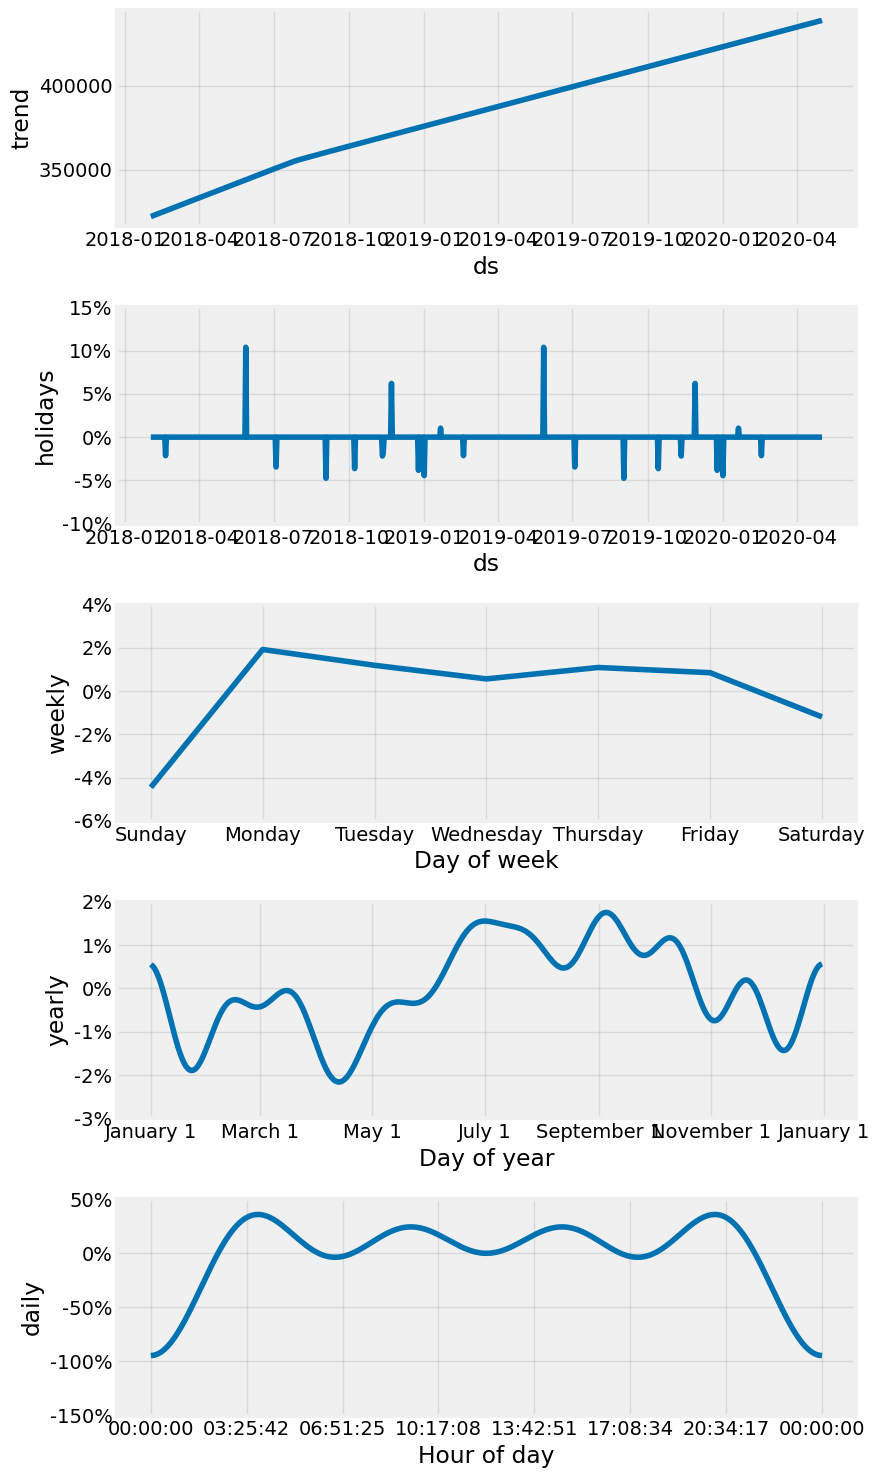

In [ ]:
# Plot the components of the model
fig = final_model.plot_components(forecast)

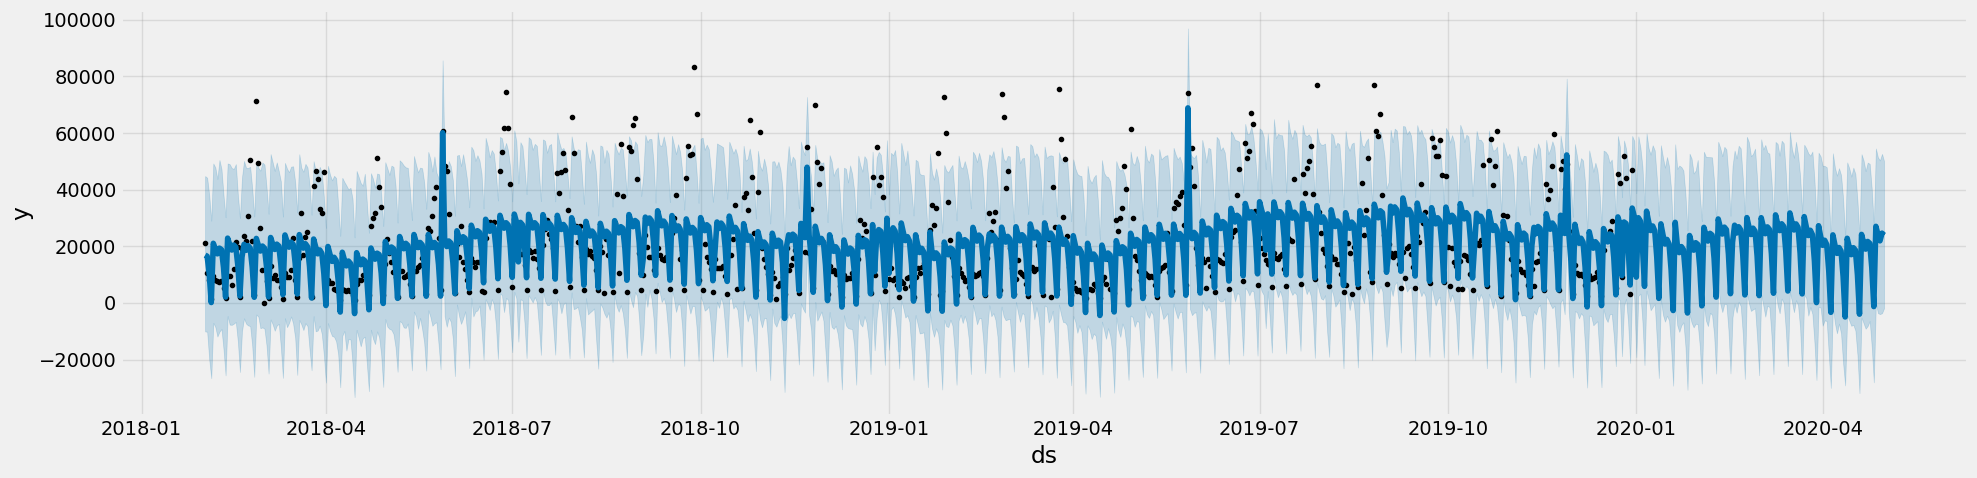

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [ ]:
X_tst_final= final_model.predict(X_tst)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
50,2020-02-20,26902.110754,-1453.916312,54998.887941
51,2020-02-21,25783.366076,-939.835741,52614.666474
52,2020-02-22,16917.645393,-9735.103695,43416.114794
53,2020-02-23,2821.474584,-25866.834208,30388.099865
54,2020-02-24,30138.206854,5819.796987,57476.664877
55,2020-02-25,26924.349978,-154.448284,54985.913639
56,2020-02-26,24162.754526,-4977.353242,50550.640075


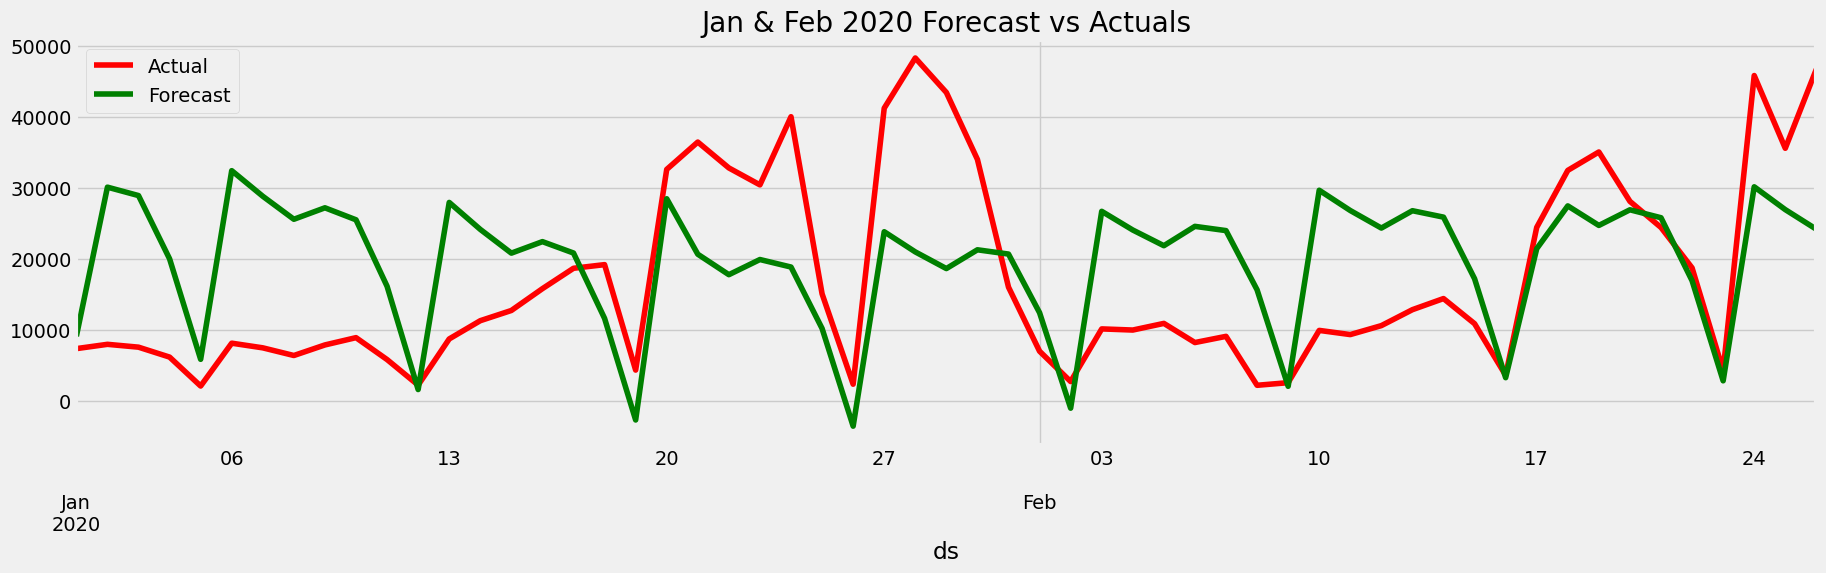

In [ ]:
f, ax = plt.subplots(figsize=(20,5))
f.set_figheight(5)
f.set_figwidth(20)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Jan & Feb 2020 Forecast vs Actuals')
plt.show()

In [ ]:
MAPE = mean_absolute_percentage_error(X_tst['y'],abs(X_tst_final['yhat']))
print('MAPE', MAPE)

MAPE 106.42912380802298


### **From the above, results, we can see there is significant improvement in MAPE. We can further improve the model by changing the fourier order of the seasonalities and by including more features and add them as additional regressors.**